<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/Navec_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 KB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 60.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import wget
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from navec import Navec

# **Get cleaned dataset**

In [3]:
PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET

if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [4]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
3536,вот так детство весь дурь из башка выбить,1
14130,пиздиля по голова твой мамаша когда она высира...,1
1054,знать один мужик деревенский он на заимка тоже...,1
13619,ладный хороший рофлить вот тот гоблин номер пр...,1
6556,большой спасибо за тёплый слово сожаление всё ...,0
9482,только вот никакой грузоперевозка по она нет н...,0
543,че пришить тем быть мы тут не бездуховный гейр...,1
1422,вы крутило бы он всё ниппель вс,0
4036,это тип как оплачивать за проезд это не новый ...,0
3309,вы я утомить честно хотеть расписать про сцена...,0


In [5]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 159.97800444074383


max:  890
min:  0
mean:  24.667291146267


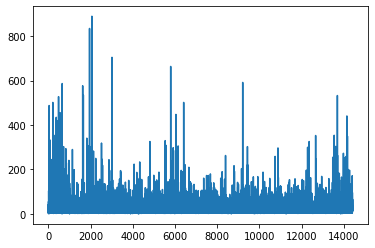

In [6]:
import statistics

print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [7]:
sentences = df.comment.values
labels = df.toxic.values

**Split**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.1, random_state=42)

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
X_train.shape

(12970,)

In [10]:
type(X_train)

numpy.ndarray

In [11]:
from navec import Navec

url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
PATH_NAVEC = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

if not os.path.exists(PATH_NAVEC):
    wget.download(url)
navec = Navec.load(PATH_NAVEC)

In [12]:
NAVEC_UNK= '<unk>'
NAVEC_PAD= '<pad>'
DIMENSION_EMBEDDING=navec.get('<unk>').shape[0]

In [13]:
def vectorize_sentence(sentence: str, vectorizer=navec,unc_token =NAVEC_UNK, pad_token = NAVEC_PAD, max_sequence_length=64) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [navec.get(t, navec[unc_token]) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [navec[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [14]:
# получить длину(количество слов) отзывов в 75% датасета
sequence_length=int(round(np.percentile(list(map(lambda sentence: len(sentence.split()), X_train)), 75)))
sequence_length

28

In [15]:
sequence_length=32

In [16]:
navec.get('<unk>').shape[0]

300

In [17]:
X_train = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_train.flatten()
    )
))

X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))


In [18]:
X_train.shape

(12970, 32, 300)

**Build RNN model**

Model: "Glove-Navec_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 256)           230656    
                                                                 
 gru (GRU)                   (None, 128)               148224    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 387,201
Trainable params: 387,201
Non

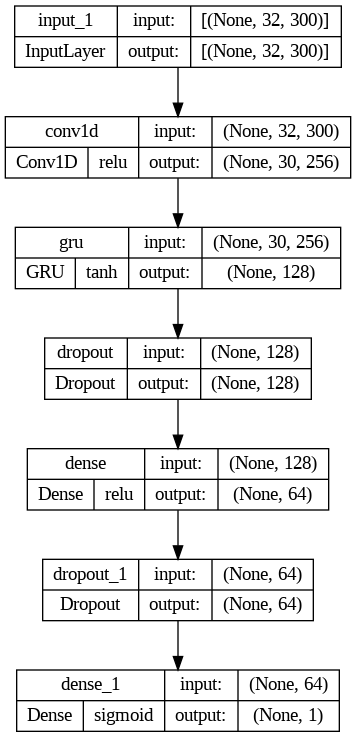

In [19]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Conv1D,GlobalMaxPool1D,SpatialDropout1D,GRU
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
SPLIT = 0.2
EPOCHS = 50
BATCH_SIZE = 512
MODEL_NAME = 'Glove-Navec_CNN'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    GRU(128, dropout=0.3, recurrent_dropout=0.1),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=7,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=SPLIT,
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/50
21/21 [==============================] - 22s 283ms/step - loss: 0.7061 - tp: 800.0000 - fp: 1234.0000 - tn: 5635.0000 - fn: 2707.0000 - accuracy: 0.6202 - precision: 0.3933 - recall: 0.2281 - auc: 0.5594 - prc: 0.3828 - val_loss: 0.7153 - val_tp: 763.0000 - val_fp: 1228.0000 - val_tn: 518.0000 - val_fn: 85.0000 - val_accuracy: 0.4938 - val_precision: 0.3832 - val_recall: 0.8998 - val_auc: 0.7734 - val_prc: 0.6618
Epoch 2/50
21/21 [==============================] - 4s 184ms/step - loss: 0.5175 - tp: 2935.0000 - fp: 2299.0000 - tn: 4570.0000 - fn: 572.0000 - accuracy: 0.7233 - precision: 0.5608 - recall: 0.8369 - auc: 0.8319 - prc: 0.7118 - val_loss: 0.3558 - val_tp: 687.0000 - val_fp: 190.0000 - val_tn: 1556.0000 - val_fn: 161.0000 - val_accuracy: 0.8647 - val_precision: 0.7834 - val_recall: 0.8101 - val_auc: 0.9250 - val_prc: 0.8478
Epoch 3/50
21/21 [==============================] - 4s 177ms/step - loss: 0.3400 - tp: 3019.0000 - fp: 772.0000 - tn: 6097.0000 - fn: 488.0000 -

**Save model**

In [21]:
model.save(MODEL_NAME)

In [22]:
pred = model.predict(X_test).flatten()

46/46 [==============================] - 1s 11ms/step


In [23]:
pred

array([0.9887177 , 0.00144481, 0.00481647, ..., 0.0033797 , 0.00368749,
       0.00265635], dtype=float32)

In [24]:
pred

array([0.9887177 , 0.00144481, 0.00481647, ..., 0.0033797 , 0.00368749,
       0.00265635], dtype=float32)

In [25]:
threshold =0.5
pred = np.where(pred<threshold,0,1)

In [26]:
pred

array([1, 0, 0, ..., 0, 0, 0])

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 90.36 %
Recall: 89.60 %
Precision: 82.42 %
F1-score: 85.86 % 

True Negatives:  881
False Positives:  90
False Negatives:  49
True Positives:  422


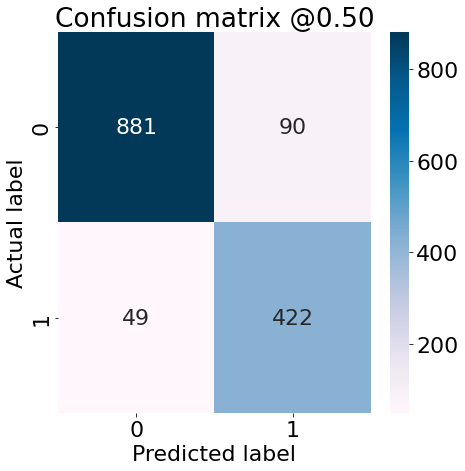

In [28]:
plot_cm(y_test, pred)

In [29]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

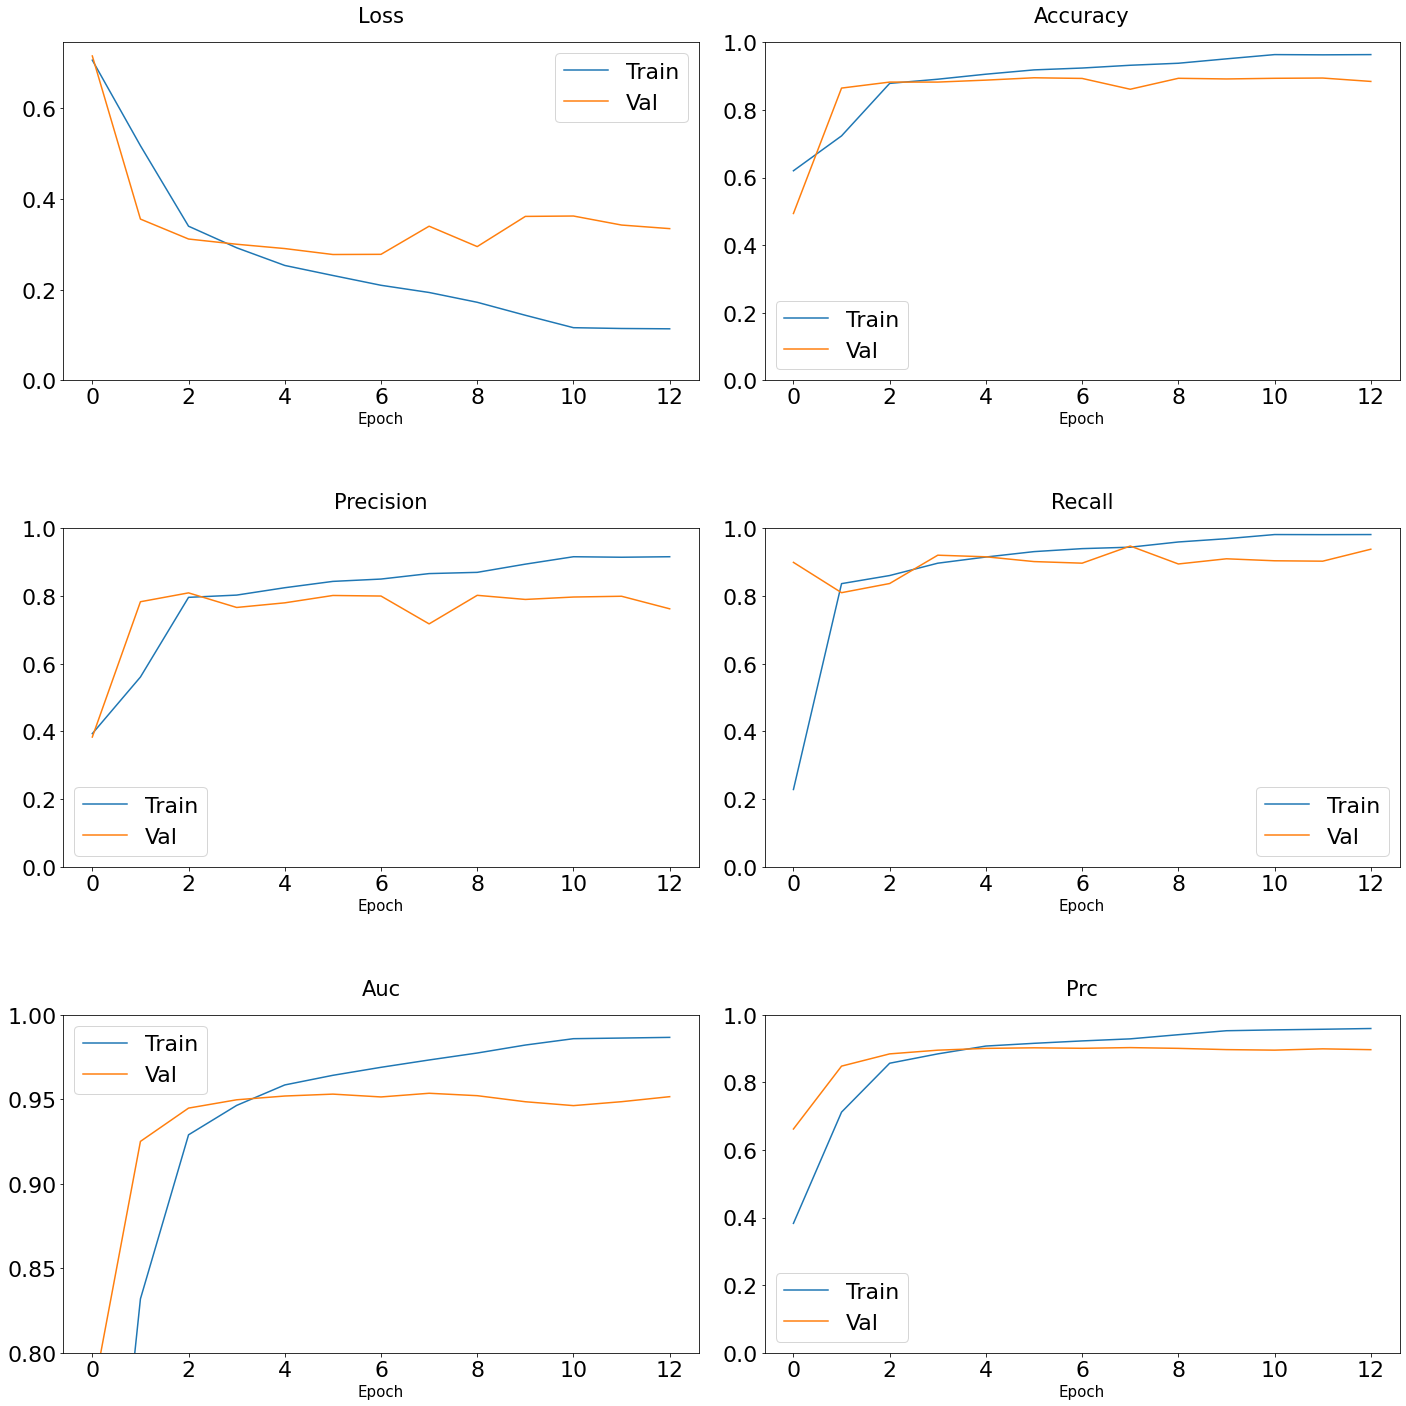

In [30]:
plot_metrics(history)

**Отобразим ROC - кривую**

46/46 [==============================] - 1s 11ms/step
: ROC AUC=0.963


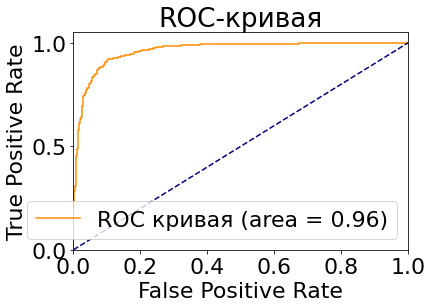

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = model.predict(X_test).flatten()
threshold =0.5
pred = np.where(pred<threshold,0,1)
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(': ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()